In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData
from pyuvdata import uvutils
from hera_qm import ant_metrics
import hera_cal
from copy import deepcopy
from scipy.signal import medfilt2d
from astropy.time import Time

from matplotlib.colors import SymLogNorm
import sys
import os
from hera_qm import xrfi as xrfi
import numpy.ma as ma
from glob import glob
import math

In [2]:

data_file_list = ['/data6/HERA/data/2458042/zen.2458042.12552.xx.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.yy.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.yx.HH.uv','/data6/HERA/data/2458042/zen.2458042.12552.xy.HH.uv']

uv = UVData()


In [3]:

uv.read_miriad(data_file_list)


Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.


In [4]:

aa = hera_cal.utils.get_aa_from_uv(uv)

info = hera_cal.omni.aa_to_info(aa)

reds = info.get_reds()


In [5]:

am = ant_metrics.Antenna_Metrics(data_file_list, reds, fileformat = 'miriad')


In [5]:

bases = []

lst = uv.get_antpairpols()

for i in range(uv.Nbls):
    
    pair = lst[4*i]
    
    bases.append((pair[0],pair[1]))
    
print bases


[(0, 0), (0, 1), (0, 2), (0, 11), (0, 12), (0, 13), (0, 14), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 65), (0, 66), (0, 67), (0, 68), (0, 69), (0, 70), (0, 71), (0, 82), (0, 83), (0, 84), (0, 85), (0, 86), (0, 87), (0, 88), (0, 98), (0, 120), (0, 121), (0, 122), (0, 123), (0, 124), (0, 141), (0, 142), (0, 143), (1, 1), (1, 2), (1, 11), (1, 12), (1, 13), (1, 14), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 65), (1, 66), (1, 67), (1, 68), (1, 69), (1, 70), (1, 71), (1, 82), (1, 83), (1, 84), (1, 85), (1, 86), (1, 87), (1, 88), (1, 98), (1, 120), (1, 121), (1, 122), (1, 123), (1, 124), (1, 141), (1, 142), (1, 143), (2, 2), (2, 11), (2, 12), (2, 13), (2, 14), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 50),

In [6]:

nonreds = []

for i in bases:
    
    flag = 0
    
    for j in reds:
        
        for k in j:
            
            if i == k:
                
                flag = 1
                
    if flag == 0:
        
        nonreds.append(i)
        
    
print nonreds


[(0, 0), (0, 98), (0, 143), (1, 1), (1, 98), (2, 2), (2, 98), (2, 120), (2, 141), (11, 11), (12, 12), (13, 13), (13, 98), (14, 14), (14, 98), (14, 120), (23, 23), (24, 24), (25, 25), (26, 26), (26, 98), (27, 27), (27, 98), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (40, 98), (41, 41), (41, 98), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (55, 98), (65, 65), (65, 124), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (71, 98), (82, 82), (83, 83), (84, 84), (85, 85), (86, 86), (87, 87), (87, 98), (88, 88), (88, 98), (98, 98), (98, 124), (98, 143), (120, 120), (121, 121), (122, 122), (123, 123), (124, 124), (141, 141), (142, 142), (143, 143)]


In [7]:

#Long Vertical Baselines (84 meters)

data0 = uv.get_data(1,85,'xx')

data1 = uv.get_data(2,86,'xx')

#Short Vertical Baselines (28 meters)

data2 = uv.get_data(11,37,'xx')

data3 = uv.get_data(12,38,'xx')

#Long Horizontal Baselines (84 meters)

data4 = uv.get_data(82,88,'xx')

data5 = uv.get_data(65,71,'xx')

#Short Horizontal Baselines (28 meters)

data6 = uv.get_data(0,2,'xx')

data7 = uv.get_data(11,13,'xx')


test1 = np.mean(np.abs(data0) * np.abs(data1),axis = 1)
test2 = np.mean(np.abs(data2) * np.abs(data3),axis = 1)
test3 = np.mean(np.abs(data4) * np.abs(data5),axis = 1)
test4 = np.mean(np.abs(data6) * np.abs(data7),axis = 1)


In [8]:

print test1.shape


(60,)


In [9]:

def new_compute_median_auto_power_dict(data, pols, reds):
    
    autoPower = {}
    for pol in pols:
        for bls in reds:
            for (i, j) in bls:
                autoPower[i, j, pol] = np.median(np.mean(np.abs(data.get_data(i, j, pol))**2, axis=1))
    return autoPower


In [10]:

autoPower = new_compute_median_auto_power_dict(uv, ['xx','xy','yx','yy'], reds)

corr1 = np.median(test1)
corr2 = np.median(test2)
corr3 = np.median(test3)
corr4 = np.median(test4)

full_corr1 = corr1/np.sqrt(autoPower[1,85,'xx']*autoPower[2,86,'xx'])
full_corr2 = corr2/np.sqrt(autoPower[11,37,'xx']*autoPower[12,38,'xx'])
full_corr3 = corr3/np.sqrt(autoPower[82,88,'xx']*autoPower[65,71,'xx'])
full_corr4 = corr4/np.sqrt(autoPower[0,2,'xx']*autoPower[11,13,'xx'])

print full_corr1
print full_corr2
print full_corr3
print full_corr4


0.992932611841
0.994130979831
0.993178356675
0.950113610965


In [11]:

antpos, ants = uv.get_ENU_antpos()


In [12]:

def red_corr_func(ant0,ant1):
    
    if (ant0 == ant1):
        
        return 0
    
    elif (ant0 < ant1):
        
        base = (ant0,ant1)
    
    elif(ant0 > ant1):
        
        base = (ant1,ant0)
    
    ind1 = 1000
    ind2 = 0
    
    for i in range(len(reds)):
        
        for j in range(len(reds[i])):
            
            if (reds[i][j] == base):
                
                ind1 = i
                ind2 = j
                
    if (ind1 == 1000):
        
        return 0
    
    else: 
        
        avg = 0
        
        count = 0
        
        for k in range(len(reds[ind1])):
            
            if (k != ind2):
                
                antenna1 = reds[ind1][k][0]
                antenna2 = reds[ind1][k][1]
                
                correlation = np.median(np.mean(np.abs(uv.get_data(base[0],base[1],'xx')) * np.abs(uv.get_data(antenna1,antenna2,'xx')),axis = 1))
                
                avg += correlation/np.sqrt(autoPower[base[0],base[1],'xx']*autoPower[antenna1,antenna2,'xx'])
                
                count += 1
                
        avg = avg / count
        
        return avg
    

In [33]:
#Removed Effects of Antenna 50, 65, 124, and 143
def red_corr_func(ant0,ant1):
    
    if (ant0 == ant1):
        
        return 0
    
    if (ant0 == 50) or (ant1 == 50) or (ant0 == 65) or (ant1 == 65) or (ant0 == 143) or (ant1 == 143) or (ant0 == 124) or (ant1 == 124):
        
        return 0.94
    
    elif (ant0 < ant1):
        
        base = (ant0,ant1)
    
    elif(ant0 > ant1):
        
        base = (ant1,ant0)
    
    ind1 = 1000
    ind2 = 0
    
    for i in range(len(reds)):
        
        for j in range(len(reds[i])):
            
            if (reds[i][j] == base):
                
                ind1 = i
                ind2 = j
                
    if (ind1 == 1000):
        
        return 0
    
    else: 
        
        avg = 0
        
        count = 0
        
        for k in range(len(reds[ind1])):
            
            if (k != ind2):
                
                antenna1 = reds[ind1][k][0]
                antenna2 = reds[ind1][k][1]
                
                correlation = np.median(np.mean(np.abs(uv.get_data(base[0],base[1],'xx')) * np.abs(uv.get_data(antenna1,antenna2,'xx')),axis = 1))
                
                avg += correlation/np.sqrt(autoPower[base[0],base[1],'xx']*autoPower[antenna1,antenna2,'xx'])
                
                count += 1
                
        avg = avg / count
        
        return avg
    

In [34]:

red_corr_storage_0 = np.zeros(ants.size)

for i in range(len(ants)):
    
    red_corr_storage_0[i] = red_corr_func(0,ants[i])

    
print red_corr_storage_0

[ 0.98577596  0.98794193  0.98194759  0.9844019   0.93573813  0.99138339
  0.94        0.          0.97600296  0.94        0.94        0.9936362
  0.98243852  0.94        0.99368975  0.98886939  0.97906948  0.98066574
  0.96913482  0.9797017   0.97332451  0.91792554  0.97997874  0.
  0.93785804  0.9196151   0.94383936  0.95202852  0.95370249  0.94739555
  0.9558398   0.9663855   0.94313076  0.93975692  0.95380051  0.98132794
  0.97701353  0.98569121  0.98677528  0.98938506  0.97027515  0.94371854
  0.93812567  0.98601382  0.97500011  0.99494898  0.99504434]


In [35]:

red_corr_storage_1 = np.zeros(ants.size)

for i in range(len(ants)):
    
    red_corr_storage_1[i] = red_corr_func(1,ants[i])

    
print red_corr_storage_1

[ 0.97731667  0.98029717  0.98031133  0.99321173  0.94910203  0.94059076
  0.94        0.          0.98155488  0.94        0.94        0.99215845
  0.99185855  0.94        0.97896862  0.99765323  0.96996866  0.99732669
  0.99525065  0.98931066  0.98079431  0.9886114   0.98851272  0.93785804
  0.          0.95387325  0.92897016  0.96644167  0.94700038  0.93535619
  0.94771061  0.95730272  0.94979133  0.96935064  0.9568744   0.93111616
  0.97788333  0.99386612  0.99535326  0.9947662   0.95906754  0.98572641
  0.9547541   0.98140219  0.9981115   0.99088094  0.99215654]


In [36]:

red_corr_storage_50 = np.zeros(ants.size)

for i in range(len(ants)):
    
    red_corr_storage_50[i] = red_corr_func(50,ants[i])

    
print red_corr_storage_50

[ 0.94  0.94  0.94  0.94  0.94  0.94  0.    0.94  0.94  0.94  0.94  0.94
  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94
  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94
  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94]


In [37]:

red_corr_storage_53 = np.zeros(ants.size)

for i in range(len(ants)):
    
    red_corr_storage_53[i] = red_corr_func(53,ants[i])

    
print red_corr_storage_53

[ 0.93996996  0.93694689  0.94791286  0.90894657  0.94876188  0.96618653
  0.94        0.87679011  0.92246532  0.94        0.94        0.93565142
  0.95991656  0.94        0.95356247  0.93742336  0.94513924  0.93469806
  0.91523577  0.8944739   0.92629042  0.93856515  0.91013852  0.97027515
  0.95906754  0.95330317  0.95242045  0.94926138  0.9072318   0.93743503
  0.93922427  0.91251254  0.89123009  0.93700309  0.94425404  0.92898768
  0.89502754  0.90940908  0.9362086   0.91981337  0.          0.91881142
  0.95234904  0.91394973  0.92220967  0.9597763   0.96571037]


In [38]:

red_corr_storage_65 = np.zeros(ants.size)

for i in range(len(ants)):
    
    red_corr_storage_65[i] = red_corr_func(65,ants[i])

    
print red_corr_storage_65

[ 0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.    0.94
  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94
  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94
  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94]


In [39]:

red_corr_storage_84 = np.zeros(ants.size)

for i in range(len(ants)):
    
    red_corr_storage_84[i] = red_corr_func(84,ants[i])

    
print red_corr_storage_84

[ 0.96460934  0.94717582  0.93663778  0.9550493   0.99303737  0.96159972
  0.94        0.94480984  0.94394368  0.94        0.94        0.95610481
  0.95356439  0.94        0.95138456  0.96100072  0.93408004  0.96455615
  0.9359328   0.96065871  0.94733766  0.94430834  0.96433056  0.98601382
  0.98140219  0.97593221  0.99167362  0.99311445  0.98191207  0.9886155
  0.98293472  0.9911436   0.96952692  0.93714611  0.92804907  0.99536227
  0.99902501  0.92764812  0.94276577  0.97429536  0.91394973  0.9471025
  0.93882032  0.          0.94550775  0.97846327  0.96707246]


In [40]:

red_corr_storage_143 = np.zeros(ants.size)

for i in range(len(ants)):
    
    red_corr_storage_143[i] = red_corr_func(143,ants[i])

    
print red_corr_storage_143

[ 0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94
  0.94  0.    0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94
  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94
  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94  0.94]


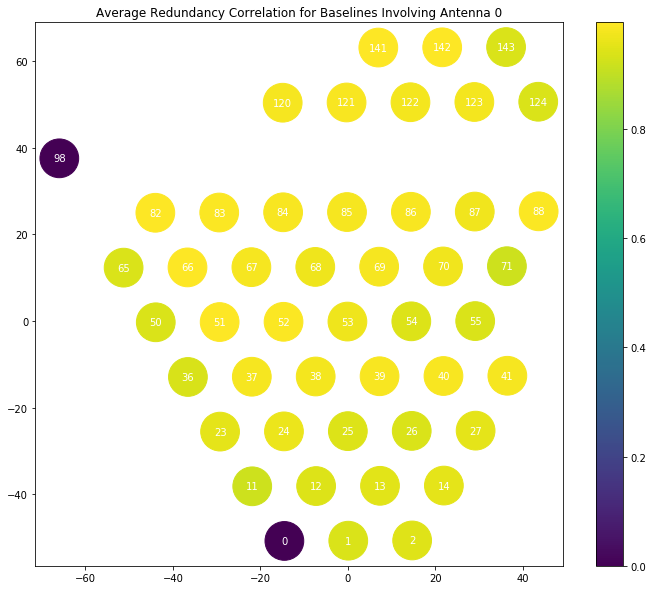

In [41]:


plt.figure(figsize=(26,10))
plt.subplot(121)
plt.scatter(antpos[:,0],antpos[:,1],c =red_corr_storage_0,marker='.',s=6000)

for aa,ant in enumerate(ants):
    plt.text(antpos[aa,0],antpos[aa,1],ants[aa],color='w',va='center',ha='center')

plt.title('Average Redundancy Correlation for Baselines Involving Antenna 0')
plt.colorbar()
plt.show()


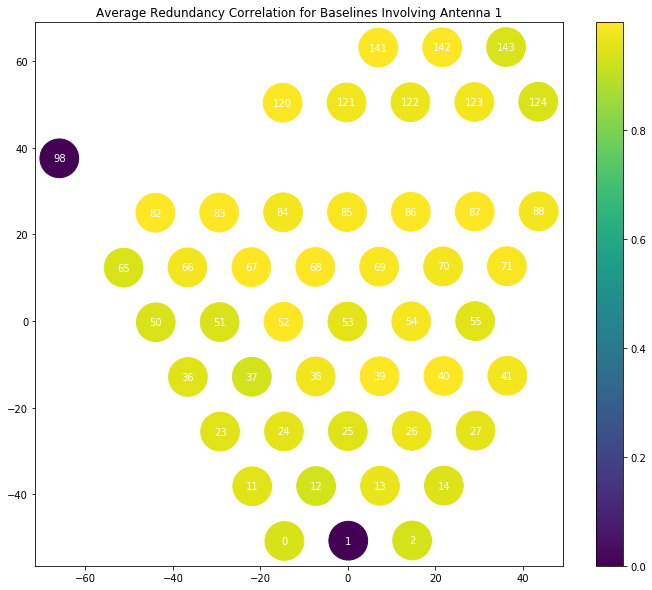

In [42]:


plt.figure(figsize=(26,10))
plt.subplot(121)
plt.scatter(antpos[:,0],antpos[:,1],c =red_corr_storage_1,marker='.',s=6000)

for aa,ant in enumerate(ants):
    plt.text(antpos[aa,0],antpos[aa,1],ants[aa],color='w',va='center',ha='center')

plt.title('Average Redundancy Correlation for Baselines Involving Antenna 1')
plt.colorbar()
plt.show()


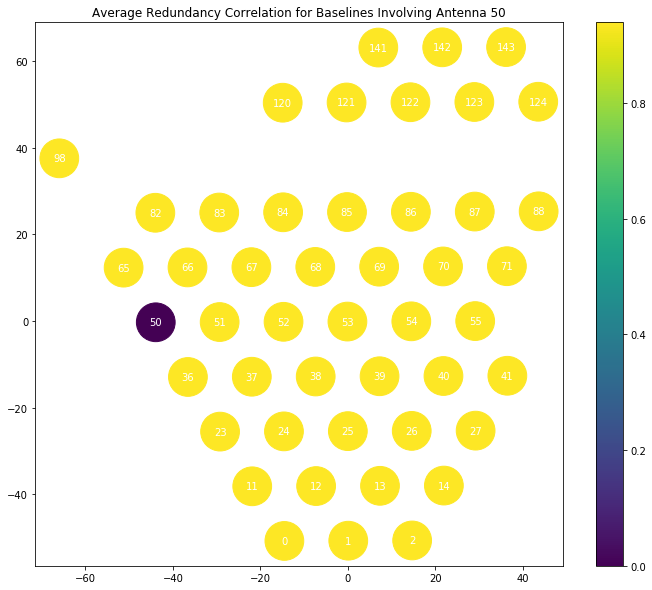

In [43]:


plt.figure(figsize=(26,10))
plt.subplot(121)
plt.scatter(antpos[:,0],antpos[:,1],c =red_corr_storage_50,marker='.',s=6000)

for aa,ant in enumerate(ants):
    plt.text(antpos[aa,0],antpos[aa,1],ants[aa],color='w',va='center',ha='center')

plt.title('Average Redundancy Correlation for Baselines Involving Antenna 50')
plt.colorbar()
plt.show()


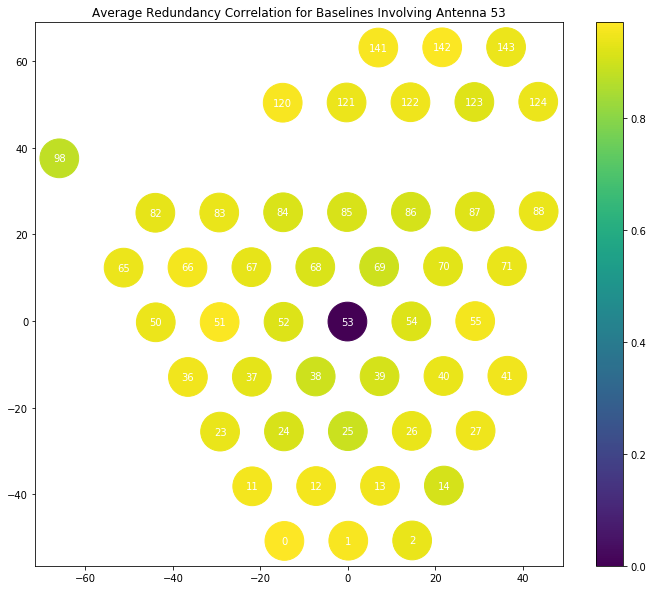

In [44]:


plt.figure(figsize=(26,10))
plt.subplot(121)
plt.scatter(antpos[:,0],antpos[:,1],c =red_corr_storage_53,marker='.',s=6000)

for aa,ant in enumerate(ants):
    plt.text(antpos[aa,0],antpos[aa,1],ants[aa],color='w',va='center',ha='center')

plt.title('Average Redundancy Correlation for Baselines Involving Antenna 53')
plt.colorbar()
plt.show()


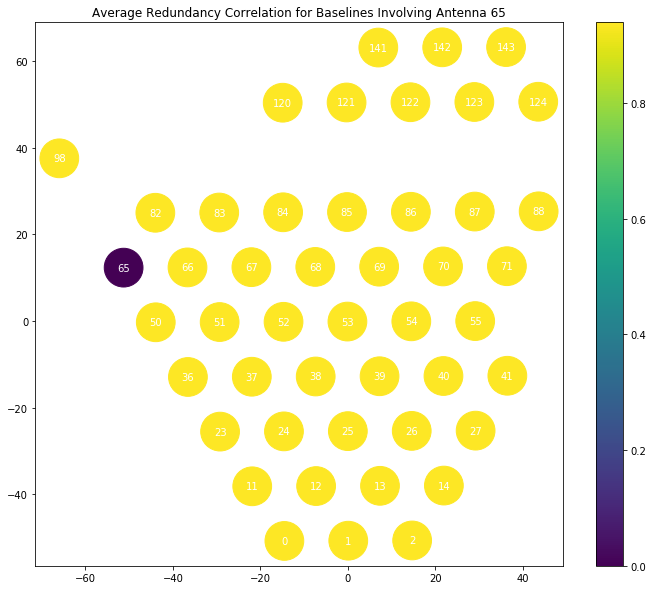

In [45]:


plt.figure(figsize=(26,10))
plt.subplot(121)
plt.scatter(antpos[:,0],antpos[:,1],c =red_corr_storage_65,marker='.',s=6000)

for aa,ant in enumerate(ants):
    plt.text(antpos[aa,0],antpos[aa,1],ants[aa],color='w',va='center',ha='center')

plt.title('Average Redundancy Correlation for Baselines Involving Antenna 65')
plt.colorbar()
plt.show()


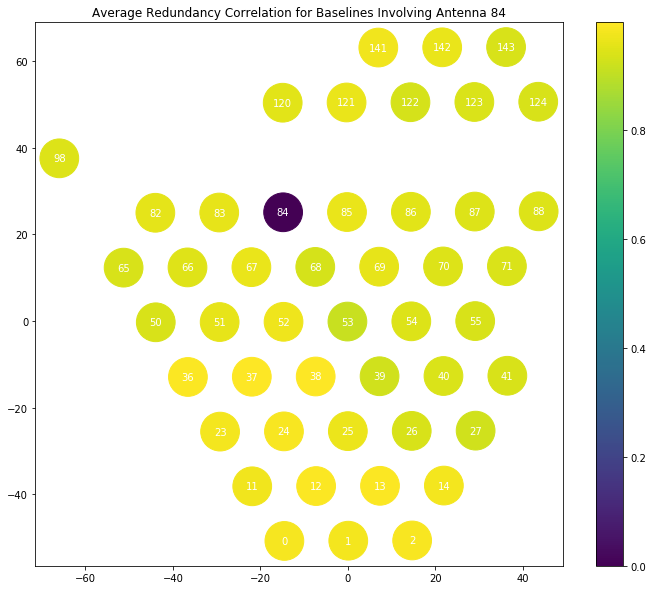

In [46]:


plt.figure(figsize=(26,10))
plt.subplot(121)
plt.scatter(antpos[:,0],antpos[:,1],c =red_corr_storage_84,marker='.',s=6000)

for aa,ant in enumerate(ants):
    plt.text(antpos[aa,0],antpos[aa,1],ants[aa],color='w',va='center',ha='center')

plt.title('Average Redundancy Correlation for Baselines Involving Antenna 84')
plt.colorbar()
plt.show()


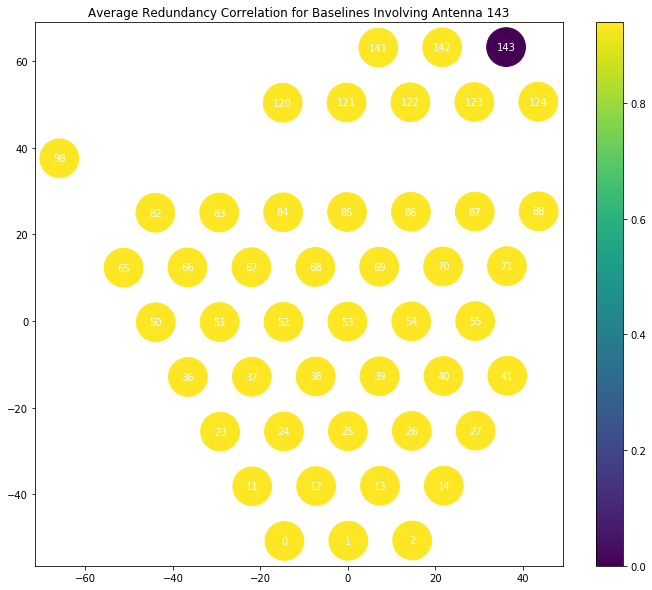

In [47]:


plt.figure(figsize=(26,10))
plt.subplot(121)
plt.scatter(antpos[:,0],antpos[:,1],c =red_corr_storage_143,marker='.',s=6000)

for aa,ant in enumerate(ants):
    plt.text(antpos[aa,0],antpos[aa,1],ants[aa],color='w',va='center',ha='center')

plt.title('Average Redundancy Correlation for Baselines Involving Antenna 143')
plt.colorbar()
plt.show()


In [48]:

nonreds_mod = []

for i in range(len(nonreds)):
    
    #Add any baseline that is not an autocorrelation
    
    if (nonreds[i][0] != nonreds[i][1]):
        
        nonreds_mod.append(nonreds[i])


#Have (0,0) be the very last baseline present in the new nonreds_mod
        
nonreds_mod.append((0, 0))


In [49]:

dist_array = np.zeros(((len(reds)+len(nonreds_mod)-1)*2+1,2)) # (n Red Baselines + m Nonred Baselines{no autocorrs})*2
                                                              # (For flipped representation)+ 1 autocorrelation = all Baselines

buff = len(reds)+len(nonreds_mod) #Add a buffer value for the flipped baselines
    
for i in range(len(reds)):
    
    #Loop through every redundant group and take the orientation from the first baseline present
    #By definition of their being redundant, this will be a suitable representation for all of them
    
    dist_array[i][0] = (antpos[np.where(reds[i][0][0]==ants)] - antpos[np.where(ants == reds[i][0][1])])[0][0]
    
    dist_array[i][1] = (antpos[np.where(reds[i][0][0]==ants)] - antpos[np.where(ants == reds[i][0][1])])[0][1]
    
    #This is done purely to make the final plot contains 360 degrees of baselines as opposed to 180
    #This will be symmetric and will not bring anything new to the plot other than a more comprehensible viewing
    
    dist_array[i+buff][0] = -(antpos[np.where(reds[i][0][0]==ants)] - antpos[np.where(ants == reds[i][0][1])])[0][0]
    
    dist_array[i+buff][1] = -(antpos[np.where(reds[i][0][0]==ants)] - antpos[np.where(ants == reds[i][0][1])])[0][1]
    
for j in range(len(nonreds_mod)):
    
    #Loop through the modified nonredundant list for completion
    #These distances will all have 0 redundancy correlation, being non-redundant, but it will allow the final 
    #Graph to represent all possible baselines
    
    dist_array[len(reds)+j][0] = (antpos[np.where(nonreds_mod[j][0]==ants)] - antpos[np.where(ants == nonreds_mod[j][1])])[0][0]
    
    dist_array[len(reds)+j][1] = (antpos[np.where(nonreds_mod[j][0]==ants)] - antpos[np.where(ants == nonreds_mod[j][1])])[0][1]
    
    if (j != len(nonreds_mod)-1): #Do not do this for baseline (0,0) as flipping it will do nothing
        
        dist_array[len(reds)+j+buff][0] = -(antpos[np.where(nonreds_mod[j][0]==ants)] - antpos[np.where(ants == nonreds_mod[j][1])])[0][0]
        dist_array[len(reds)+j+buff][1] = -(antpos[np.where(nonreds_mod[j][0]==ants)] - antpos[np.where(ants == nonreds_mod[j][1])])[0][1]


In [50]:

red_metric_store = np.zeros(dist_array.shape)

buff = len(reds)+len(nonreds_mod) #This buff value will have the same purpose as before

for i in range(len(ants)):
    
    print i
    
    for j in range(len(ants)):
        
        flag = False 
        #This flag will be used to determine whether the baseline is redundant or not. True = yes, False = no
        
        for k in range(len(reds)):
            
            for l in range(len(reds[k])):
                
                if ((ants[i],ants[j]) == reds[k][l]):
                    
                    red_metric_store[k][0] += red_corr_func(ants[i],ants[j])
                    
                    red_metric_store[k][1] += 1
                    
                    flag = True
                    
                    break
                
                #This else statement is used for all the reverse baselines which will allow for a more complete (mirrored) plot
                
                elif ((ants[j],ants[i]) == reds[k][l]): 
                    
                    red_metric_store[k+buff][0] += red_corr_func(ants[i],ants[j])
                    
                    red_metric_store[k+buff][1] += 1
                    
                    flag = True
                    
                    break
                    
            if flag: #If Flag is true, then the baseline was redundant, and there is no need to loop through the nonredundants
                
                break
                
        if not flag: #If not Flag is true, then the baseline was not redundant
            
            #The redundancy correlation for all of these antenna should be 0, this is simply a check to ensure that this is
            #The case and that the code is working properly. If one of the following indices is non-zero, then something 
            #Has occurred and the final result is innaccurate. Additionally, The count for each index, excluding the autos, 
            #Should be one. This is another check. Should The following cells return division by zero errors, then this is
            #Another wairning the code is not working as expected.
            
            for m in range(len(nonreds_mod)):
                
                if (ants[i] == ants[j]): #Autocorrelations
                    
                    red_metric_store[buff-1][0] += red_corr_func(ants[i],ants[j])
                    
                    red_metric_store[buff-1][1] += 1
                    
                    break
                
                elif ((ants[i],ants[j]) == nonreds_mod[m]):
                    
                    red_metric_store[m+len(reds)][0] += red_corr_func(ants[i],ants[j])
                    
                    red_metric_store[m+len(reds)][1] += 1
                    
                    break
                    
                elif ((ants[j],ants[i]) == nonreds_mod[m]):
                    
                    index = np.where(nonreds_mod == (ants[j],ants[i]))
                    
                    red_metric_store[m+len(reds)+buff][0] += red_corr_func(ants[i],ants[j])
                    
                    red_metric_store[m+len(reds)+buff][1] += 1
                    
                    break


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


In [51]:

avg_val_holder = np.zeros(red_metric_store.shape[0])

for i in range(len(red_metric_store)):
    
    #Divide the sum by the number of times the function was called

    avg_val_holder[i] = red_metric_store[i][0] / red_metric_store[i][1] 
    

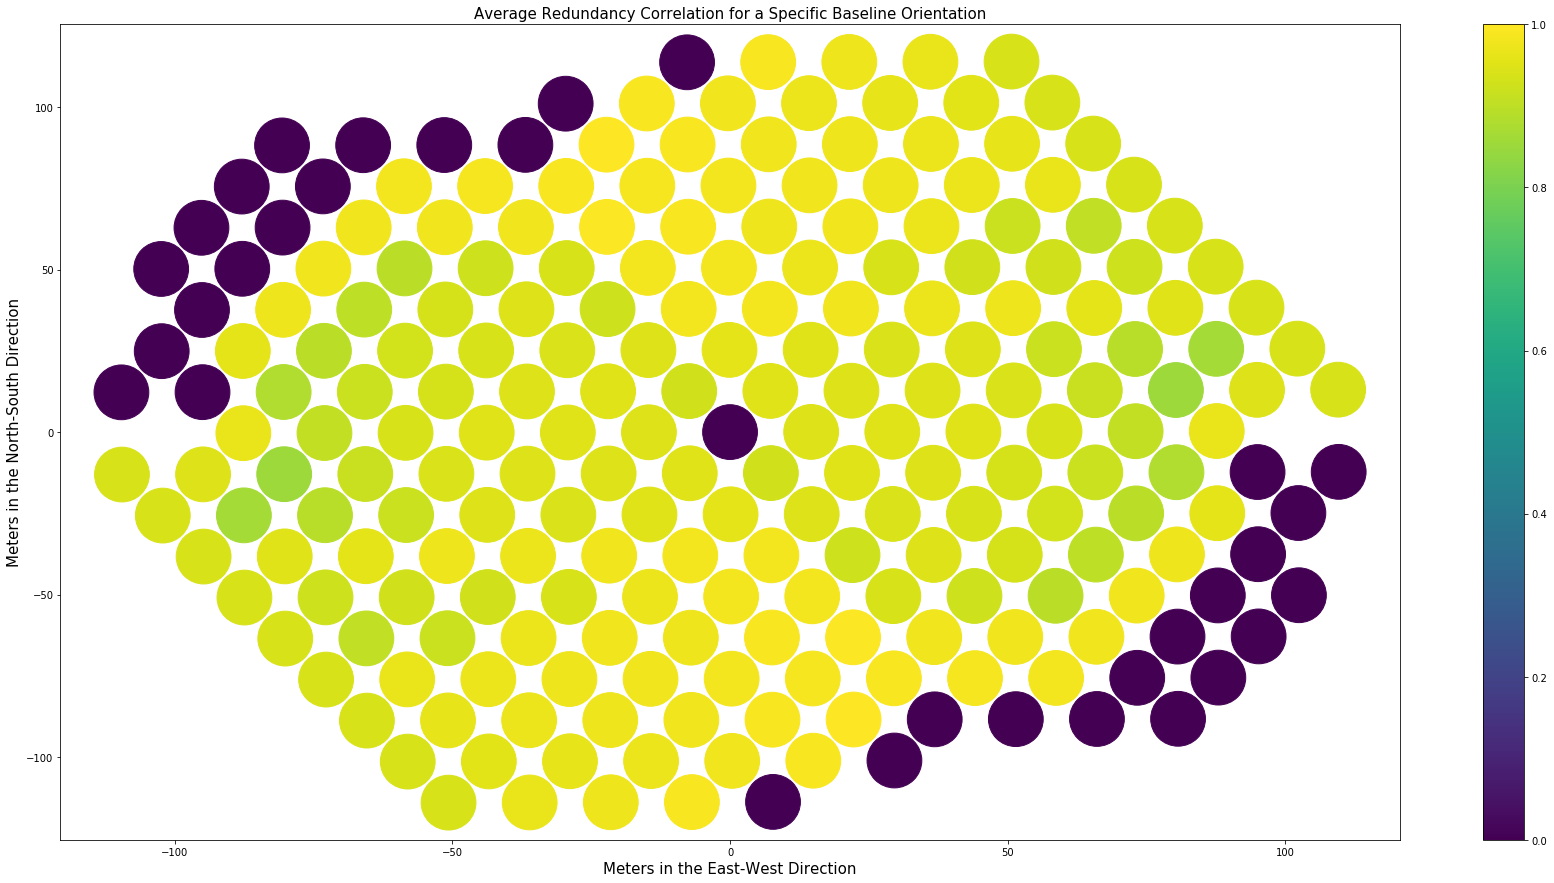

In [52]:

plt.figure(figsize = (30,15))

plt.scatter(dist_array[:,0], dist_array[:,1],c=avg_val_holder,s=3000,vmin = 0,vmax = 1)

plt.colorbar()

plt.title('Average Redundancy Correlation for a Specific Baseline Orientation', size = '15')
plt.xlabel('Meters in the East-West Direction',size = '15')
plt.ylabel('Meters in the North-South Direction',size = '15')

plt.show()

plt.close()


In [21]:
def make_scatter(dist_array,avg_val_holder,file_name,path):
    
    plt.figure(figsize = (30,15))
    plt.scatter(dist_array[:,0], dist_array[:,1],c=avg_val_holder,s=3000,vmin=0,vmax =1)
    plt.colorbar()
    plt.title('Average Redundancy Correlation for Observation: ' + file_name, size = '15')
    plt.xlabel('Meters in the East-West Direction',size = '15')
    plt.ylabel('Meters in the North-South Direction',size = '15')
    plt.annotate('LST: ', (83,100),size = '15')
    plt.annotate(t.sidereal_time('apparent',longitude = (21,25,42)),(90,100), size = '15')
    plt.savefig(path + file_name+'_redundancy_correlation_plot.pdf', format = 'pdf')
    plt.close()

In [22]:

def red_corr_func(ant0,ant1):
    
    if (ant0 == ant1):
        
        return 0
    
    elif (ant0 < ant1):
        
        base = (ant0,ant1)
    
    elif(ant0 > ant1):
        
        base = (ant1,ant0)
    
    ind1 = 1000
    ind2 = 0
    
    for i in range(len(reds)):
        
        for j in range(len(reds[i])):
            
            if (reds[i][j] == base):
                
                ind1 = i
                ind2 = j
                
    if (ind1 == 1000):
        
        return 0
    
    else: 
        
        avg = 0
        
        count = 0
        
        for k in range(len(reds[ind1])):
            
            if (k != ind2):
                
                antenna1 = reds[ind1][k][0]
                antenna2 = reds[ind1][k][1]
                
                correlation = np.median(np.mean(np.abs(uv.get_data(base[0],base[1],'xx')) * np.abs(uv.get_data(antenna1,antenna2,'xx')),axis = 1))
                
                avg += correlation/np.sqrt(autoPower[base[0],base[1],'xx']*autoPower[antenna1,antenna2,'xx'])
                
                count += 1
                
        avg = avg / count
        
        return avg
        
        
        

In [23]:
def make_red_metric_store():

    red_metric_store = np.zeros(dist_array.shape)

    buff = len(reds)+len(nonreds_mod) #This buff value will have the same purpose as before

    for i in range(len(ants)):

        for j in range(len(ants)):

            flag = False 
            #This flag will be used to determine whether the baseline is redundant or not. True = yes, False = no

            for k in range(len(reds)):

                for l in range(len(reds[k])):

                    if ((ants[i],ants[j]) == reds[k][l]):

                        red_metric_store[k][0] += red_corr_func(ants[i],ants[j])

                        red_metric_store[k][1] += 1

                        flag = True

                        break

                    #This else statement is used for all the reverse baselines which will allow for a more complete (mirrored) plot

                    elif ((ants[j],ants[i]) == reds[k][l]): 

                        red_metric_store[k+buff][0] += red_corr_func(ants[i],ants[j])

                        red_metric_store[k+buff][1] += 1

                        flag = True

                        break

                if flag: #If Flag is true, then the baseline was redundant, and there is no need to loop through the nonredundants

                    break

            if not flag: #If not Flag is true, then the baseline was not redundant

                #The redundancy correlation for all of these antenna should be 0, this is simply a check to ensure that this is
                #The case and that the code is working properly. If one of the following indices is non-zero, then something 
                #Has occurred and the final result is innaccurate. Additionally, The count for each index, excluding the autos, 
                #Should be one. This is another check. Should The following cells return division by zero errors, then this is
                #Another wairning the code is not working as expected.

                for m in range(len(nonreds_mod)):

                    if (ants[i] == ants[j]): #Autocorrelations

                        red_metric_store[buff-1][0] += red_corr_func(ants[i],ants[j])

                        red_metric_store[buff-1][1] += 1

                        break

                    elif ((ants[i],ants[j]) == nonreds_mod[m]):

                        red_metric_store[m+len(reds)][0] += red_corr_func(ants[i],ants[j])

                        red_metric_store[m+len(reds)][1] += 1

                        break

                    elif ((ants[j],ants[i]) == nonreds_mod[m]):

                        index = np.where(nonreds_mod == (ants[j],ants[i]))

                        red_metric_store[m+len(reds)+buff][0] += red_corr_func(ants[i],ants[j])

                        red_metric_store[m+len(reds)+buff][1] += 1

                        break
                        
    return red_metric_store


In [36]:

files = np.sort(glob('/data6/HERA/data/2458042/zen.2458042.6*.xx.HH.uv'))

uv.read_miriad(files[0])


In [37]:

aa = hera_cal.utils.get_aa_from_uv(uv)

info = hera_cal.omni.aa_to_info(aa)

reds = info.get_reds()

bases = []

lst = uv.get_antpairpols()

for i in range(uv.Nbls):
    
    pair = lst[i]
    
    bases.append((pair[0],pair[1]))

nonreds = []

for i in bases:
    
    flag = 0
    
    for j in reds:
        
        for k in j:
            
            if i == k:
                
                flag = 1
                
    if flag == 0:
        
        nonreds.append(i)

antpos, ants = uv.get_ENU_antpos()


In [38]:
nonreds_mod = []

for i in range(len(nonreds)):
    
    #Add any baseline that is not an autocorrelation
    
    if (nonreds[i][0] != nonreds[i][1]):
        
        nonreds_mod.append(nonreds[i])


#Have (0,0) be the very last baseline present in the new nonreds_mod
        
nonreds_mod.append((0, 0))

In [39]:
dist_array = np.zeros(((len(reds)+len(nonreds_mod)-1)*2+1,2)) # (n Red Baselines + m Nonred Baselines{no autocorrs})*2
                                                              # (For flipped representation)+ 1 autocorrelation = all Baselines

buff = len(reds)+len(nonreds_mod) #Add a buffer value for the flipped baselines
    
for i in range(len(reds)):
    
    #Loop through every redundant group and take the orientation from the first baseline present
    #By definition of their being redundant, this will be a suitable representation for all of them
    
    dist_array[i][0] = (antpos[np.where(reds[i][0][0]==ants)] - antpos[np.where(ants == reds[i][0][1])])[0][0]
    
    dist_array[i][1] = (antpos[np.where(reds[i][0][0]==ants)] - antpos[np.where(ants == reds[i][0][1])])[0][1]
    
    #This is done purely to make the final plot contains 360 degrees of baselines as opposed to 180
    #This will be symmetric and will not bring anything new to the plot other than a more comprehensible viewing
    
    dist_array[i+buff][0] = -(antpos[np.where(reds[i][0][0]==ants)] - antpos[np.where(ants == reds[i][0][1])])[0][0]
    
    dist_array[i+buff][1] = -(antpos[np.where(reds[i][0][0]==ants)] - antpos[np.where(ants == reds[i][0][1])])[0][1]
    
for j in range(len(nonreds_mod)):
    
    #Loop through the modified nonredundant list for completion
    #These distances will all have 0 redundancy correlation, being non-redundant, but it will allow the final 
    #Graph to represent all possible baselines
    
    dist_array[len(reds)+j][0] = (antpos[np.where(nonreds_mod[j][0]==ants)] - antpos[np.where(ants == nonreds_mod[j][1])])[0][0]
    
    dist_array[len(reds)+j][1] = (antpos[np.where(nonreds_mod[j][0]==ants)] - antpos[np.where(ants == nonreds_mod[j][1])])[0][1]
    
    if (j != len(nonreds_mod)-1): #Do not do this for baseline (0,0) as flipping it will do nothing
        
        dist_array[len(reds)+j+buff][0] = -(antpos[np.where(nonreds_mod[j][0]==ants)] - antpos[np.where(ants == nonreds_mod[j][1])])[0][0]
        dist_array[len(reds)+j+buff][1] = -(antpos[np.where(nonreds_mod[j][0]==ants)] - antpos[np.where(ants == nonreds_mod[j][1])])[0][1]
    

In [40]:
def make_avg_val_holder(red_metric_store):

    avg_val_holder = np.zeros(red_metric_store.shape[0])

    for i in range(len(red_metric_store)):

        avg_val_holder[i] = red_metric_store[i][0] / red_metric_store[i][1]
        
    return avg_val_holder

In [41]:
for time in files:
    
    print time
    
    uv.read_miriad(time)
    
    file_name = time[29:36]+'_'+time[37:42]
    
    t = Time(float(time[29:42]),format = 'jd')
    
    autoPower = new_compute_median_auto_power_dict(uv, ['xx'], reds)
    
    metric_holder = make_red_metric_store()
    
    avg_holder = make_avg_val_holder(metric_holder)
    
    path = '/home/shane/HERA_data/HERA_imaging/redundancy_analysis/red_corr_position_plots/2458042_new/'
    
    make_scatter(dist_array,avg_holder,file_name,path)
    

/data6/HERA/data/2458042/zen.2458042.60274.xx.HH.uv
/data6/HERA/data/2458042/zen.2458042.61020.xx.HH.uv
/data6/HERA/data/2458042/zen.2458042.61765.xx.HH.uv
/data6/HERA/data/2458042/zen.2458042.62511.xx.HH.uv
/data6/HERA/data/2458042/zen.2458042.63256.xx.HH.uv
/data6/HERA/data/2458042/zen.2458042.64002.xx.HH.uv
/data6/HERA/data/2458042/zen.2458042.64748.xx.HH.uv
/data6/HERA/data/2458042/zen.2458042.65493.xx.HH.uv
/data6/HERA/data/2458042/zen.2458042.66239.xx.HH.uv
